In [1]:
import pickle
import gensim
import numpy as np
import nltk
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize,sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset with selected sections

In [2]:
with open('sample_data_1.p', 'rb') as f:
    data_dict = pickle.load(f)

In [3]:
df_1 = pd.DataFrame({'Country': data_dict['Country'],
                  'Projected Year': data_dict['ProjectedYear'],
                  'Published Date': data_dict['PublishedDate'],
                  'Content': data_dict['Content']})

In [4]:
df_1['Published Year'] = df_1['Published Date'].apply(lambda t: t.year)

In [5]:
df_1 = df_1.loc[df_1['Content'].str.len() != 0]

In [6]:
df_1.head(5)

Content        Country  \
0  INTERNATIONAL MONETARY FUNDUNITED STATES OF AM...  United States   
1  ContentsIII. The Real Effective Value of the U...  United States   
2  ContentsIV. Trends in the International Use of...  United States   
3  ContentsV. Capital Flows and Exchange Rate Vol...  United States   
4  ContentsVI. Asymmetries in the U.S. Output-Inf...  United States   

   Projected Year Published Date  Published Year  
0            1996     1995-10-03            1995  
1            1996     1995-10-03            1995  
2            1996     1995-10-03            1995  
3            1996     1995-10-03            1995  
4            1996     1995-10-03            1995

### Load dataset with manually selected paragraphs

In [7]:
df_2 = pd.read_excel('ArticleIV_sample.xlsx')

In [8]:
df_2.head(5)

Country  Published Year                                            Content
0     USA            2003  The 2003 consultation took place against the b...
1     USA            2004  The 2004 consultation discussions took place a...
2     USA            2005  The U.S. expansion solidified during the past ...
3     USA            2006  The U.S. economy has continued to be an engine...
4     USA            2008  The economy has shown remarkable resilience to...

### Load dataset with full documents

In [9]:
with open('USA_processed_xml.p', 'rb') as f:
    US_data = pickle.load(f)

with open('UK_processed_xml.p', 'rb') as f:
    UK_data = pickle.load(f)

In [10]:
#Function to create a dataframe from a document object
def create_df_from_doc_obj(doc_obj):
    df = pd.DataFrame({'doc_seriesNo': doc_obj.series_id,
                       'doc_PublisherId': doc_obj.PublisherId,
                        'Country': doc_obj.country,
                         'Projected Year': doc_obj.ProjectedYear,
                        'Published Date': doc_obj.PublicationDate,
                        'Para_id': range(len(doc_obj.paras)),
                        'Paragraph': doc_obj.paras})
    df = df[['doc_seriesNo','doc_PublisherId','Country','Projected Year','Published Date','Para_id','Paragraph']]
    
    return df

In [11]:
US_df = pd.DataFrame()
for doc in US_data:
    df = create_df_from_doc_obj(US_data[doc])
    US_df = US_df.append(df)

UK_df = pd.DataFrame()
for doc in UK_data:
    df = create_df_from_doc_obj(UK_data[doc])
    UK_df = UK_df.append(df)
    
df_3 = pd.concat([US_df, UK_df])

## Try using a list of positive and negative vocabulary

1. Search negative and positive words in each paragraph of a document
2. Negate positive words within 3 words of negative words ('not','no','nobody','none','never','neither','cannot')
3. Do not negate negative words
4. Calculate a sentiment index by country and period:
        index = (#Positive words - #Negative words) / #Total words


Reference: 
Correa, Ricardo, Keshav Garud, Juan M. Londono, and
Nathan Mislang (2017). Sentiment in Central Banks’ Financial
Stability Reports. International Finance Discussion Papers 1203. 

In [12]:
sentiment_words = pd.read_csv('sentiment_words.csv')

In [13]:
pos_words = [word for word in sentiment_words.pos if isinstance(word, str) ]
neg_words = [word for word in sentiment_words.neg if isinstance(word, str) ]

pos_words_1 = ['\\b'+word+'\\b' for word in pos_words] #to find exact words
neg_words_1 = ['\\b'+word+'\\b' for word in neg_words]

pos_pattern = '|'.join(pos_words_1)
neg_pattern = '|'.join(neg_words_1)

In [14]:
df_1['No_pos_words'] = df_1.Content.apply(lambda para: len(re.findall(pos_pattern, para, flags=re.IGNORECASE)))
df_1['No_neg_words'] = df_1.Content.apply(lambda para: len(re.findall(neg_pattern, para, flags=re.IGNORECASE)))

df_2['No_pos_words'] = df_2.Content.apply(lambda para: len(re.findall(pos_pattern, para, flags=re.IGNORECASE)))
df_2['No_neg_words'] = df_2.Content.apply(lambda para: len(re.findall(neg_pattern, para, flags=re.IGNORECASE)))

df_3['No_pos_words'] = df_3.Paragraph.apply(lambda para: len(re.findall(pos_pattern, para, flags=re.IGNORECASE)))
df_3['No_neg_words'] = df_3.Paragraph.apply(lambda para: len(re.findall(neg_pattern, para, flags=re.IGNORECASE)))

In [15]:
from nltk.corpus import stopwords

negation_list = ['not','no','nobody','none','never','neither','cannot']

stopw = stopwords.words('english')
stopw = [s for s in stopw if s not in negation_list]
lemmatizer = WordNetLemmatizer()


#Function to get a list of 3 words before and after the keyword
def get_words_to_check_negation(words, idx, ran = 3):
    sent_length = len(words)
    nidx = [idx-ran, idx+ran]
    if nidx[0]<0: nidx[0]= 0
    if nidx[1] >sent_length+1: nidx[1] = sent_length+1
    negation_checklist = words[nidx[0]: nidx[1]]
    return negation_checklist


#Function to count number of positive words and negative words in a paragraph
def count_pos_neg_words(paragraph, negation_list):
    #1. Tokenize sentence:
    sent = sent_tokenize(paragraph)
    #2. Tokenize words in a sentence and calculate positive and negative words:
    pos = 0
    neg = 0
    for s in sent:
        words = word_tokenize(s.lower())
        for idx, w in enumerate(words):
            if w in pos_words:               
                negation_check = get_words_to_check_negation(words, idx, 3)
                list_negation = [t for t in negation_check if t in negation_list]
                if len(list_negation) == 0: pos+=1
                else: neg+=1
            elif w in neg_words:
                neg+=1
    return pos, neg

#Function to get the count of tokens in a paragraph
def count_number_of_tokens(paragraph, negation_list, lemmatizer, stopw):
    tokens = word_tokenize(paragraph.lower())
    tokens = [t for t in tokens if t.isalpha()] #to eliminate non characters
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in stopw]
    return len(tokens)

In [16]:
df_1['sentiment'] = df_1.Content.apply(lambda para: 
                                           count_pos_neg_words(para,negation_list))
df_1['total_tokens'] = df_1.Content.apply(lambda para: 
                                              count_number_of_tokens(para,negation_list, lemmatizer, stopw))
df_1[['sentiment_pos','sentiment_neg']] = df_1.sentiment.apply(pd.Series)


df_2['sentiment'] = df_2.Content.apply(lambda para: 
                                           count_pos_neg_words(para,negation_list))
df_2['total_tokens'] = df_2.Content.apply(lambda para: 
                                              count_number_of_tokens(para,negation_list, lemmatizer, stopw))
df_2[['sentiment_pos','sentiment_neg']] = df_2.sentiment.apply(pd.Series)


df_3['sentiment'] = df_3.Paragraph.apply(lambda para: 
                                           count_pos_neg_words(para,negation_list))
df_3['total_tokens'] = df_3.Paragraph.apply(lambda para: 
                                              count_number_of_tokens(para,negation_list, lemmatizer, stopw))
df_3[['sentiment_pos','sentiment_neg']] = df_3.sentiment.apply(pd.Series)

In [17]:
unique_df_1 = df_1.groupby(['Country','Published Year'], 
                             as_index = False)['sentiment_pos',
                                               'sentiment_neg',
                                                'total_tokens'].sum()

unique_df_1['sentiment_index'] = (unique_df_1.sentiment_pos - unique_df_1.sentiment_neg)/unique_df_1.total_tokens


df_2['sentiment_index'] = (df_2.sentiment_pos - df_2.sentiment_neg)/df_2.total_tokens

df_3['Published Year'] = df_3['Published Date'].apply(lambda t: t.year)
unique_df_3 = df_3.groupby(['Country','Published Year'], 
                             as_index = False)['sentiment_pos',
                                               'sentiment_neg',
                                                'total_tokens'].sum()

unique_df_3['sentiment_index'] = (unique_df_3.sentiment_pos - unique_df_3.sentiment_neg)/unique_df_3.total_tokens

In [18]:
unique_df_1.head(3)

Country  Published Year  sentiment_pos  sentiment_neg  total_tokens  \
0  United Kingdom            1996            258            318         25648   
1  United Kingdom            1998            134            172         11288   
2  United Kingdom            1999             75            108          6943   

   sentiment_index  
0        -0.002339  
1        -0.003366  
2        -0.004753

In [19]:
df_2.head(3)

Country  Published Year                                            Content  \
0     USA            2003  The 2003 consultation took place against the b...   
1     USA            2004  The 2004 consultation discussions took place a...   
2     USA            2005  The U.S. expansion solidified during the past ...   

   No_pos_words  No_neg_words sentiment  total_tokens  sentiment_pos  \
0             3             5    (3, 5)            61              3   
1             4             4    (4, 4)            56              4   
2             1             0    (1, 0)            38              1   

   sentiment_neg  sentiment_index  
0              5        -0.032787  
1              4         0.000000  
2              0         0.026316

In [20]:
unique_df_3.head(3)

Country  Published Year  sentiment_pos  sentiment_neg  total_tokens  \
0  United Kingdom            1996            304            323         26539   
1  United Kingdom            1998            139            155         10311   
2  United Kingdom            1999            104            146          9791   

   sentiment_index  
0        -0.000716  
1        -0.001552  
2        -0.004290

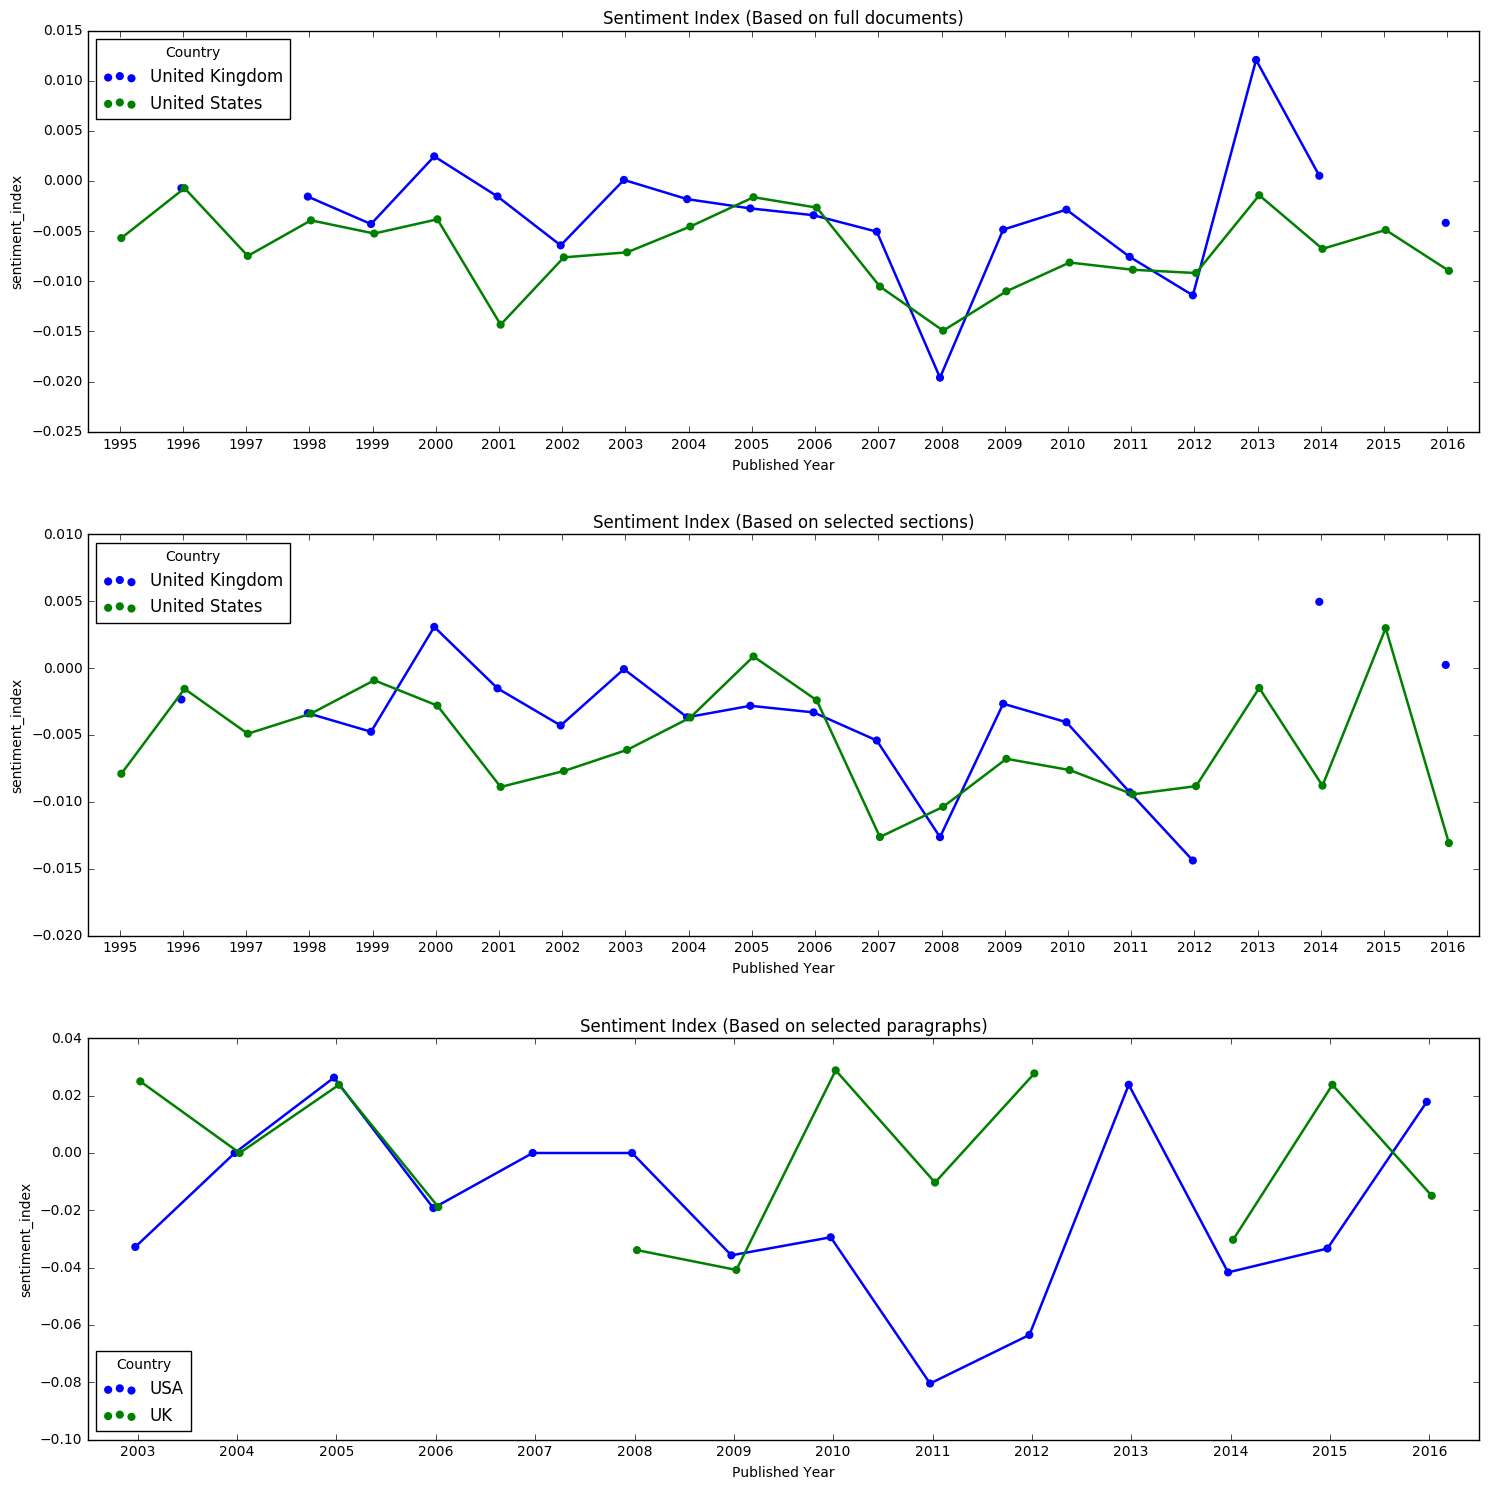

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

sns.pointplot(y = 'sentiment_index', x= 'Published Year',hue = 'Country', data = unique_df_3, dodge=True, ax = ax1)
sns.pointplot(y = 'sentiment_index', x= 'Published Year',hue = 'Country', data = unique_df_1, dodge=True, ax = ax2)
sns.pointplot(y = 'sentiment_index', x= 'Published Year',hue = 'Country', data = df_2, dodge=True, ax = ax3)

ax1.set_title('Sentiment Index (Based on full documents)')
ax2.set_title('Sentiment Index (Based on selected sections)')
ax3.set_title('Sentiment Index (Based on selected paragraphs)')

plt.tight_layout(h_pad=3,w_pad =3)

### Compare with GDP Growth


In [30]:
from IPython.display import HTML
HTML('''<iframe src="https://data.worldbank.org/share/widget?end=2016&indicators=NY.GDP.MKTP.KD.ZG&locations=US-GB&start=1994" width='450' height='300' frameBorder='0' scrolling="no" ></iframe>''')